# Portfolio Optimization

## Packages and Global Variables

In [2]:
# Import packages
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sci_opt
import requests
import json

In [3]:
# Proper Column Names for scenario metrics
scenario_metric_columns = ['Scenario', 'Period', 'Returns', 'Volatility', 'Sharpe Ratio', 'Portfolio Weights']

# Calculate the 1, 5 and 10 years parameters
periods = [1, 5, 10]

## Import list of EFT symbols from web

In [4]:
url = "https://api.stockanalysis.com/api/index/page/etfs"
response = requests.get(url)
data = json.loads(response.text)

# Read the content in data['data']['data'] into a pandas dataframe
etfs_df = pd.DataFrame(data['data']['data'])

# Print info
print(etfs_df.info())

# Display the first few rows of the dataframe
print(etfs_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3557 entries, 0 to 3556
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s       3557 non-null   object 
 1   n       3557 non-null   object 
 2   i       3536 non-null   object 
 3   m       3549 non-null   float64
dtypes: float64(1), object(3)
memory usage: 111.3+ KB
None
      s                                               n             i  \
0   AAA  Alternative Access First Priority CLO Bond ETF  Fixed Income   
1  AAAU                 Goldman Sachs Physical Gold ETF     Commodity   
2  AADR             AdvisorShares Dorsey Wright ADR ETF        Equity   
3  AAPB            GraniteShares 2x Long AAPL Daily ETF        Equity   
4  AAPD          Direxion Daily AAPL Bear 1X Shares ETF        Equity   

             m  
0   22590146.0  
1  719724900.0  
2   25741300.0  
3   36431930.0  
4   21525618.0  


## Create a list of securities to include in the optimization

In [5]:
# List of securities
original_funds = ['TECB', 'SCHE', 'SCHF', 'SCHV', 'SCHG', 'KOMP', 'MDYG', 'MDYV', 'SLYG', 'SLYV', 'OSMAX', 'USMV', 'SBSPX', 'VOO']
bdc_funds = ['ARCC', 'MAIN', 'CSWC', 'HTGC']
citi_growth_screener = ['FDMO', 'IDMO', 'QGRO', 'FTC', 'PWV', 'IMTM', 'TTAC', 'IVE', 'EQWL', 'DIA', 'IDHQ', 'MGV', 'VTV', 'DLN', 'HSCZ', 'HAWX', 'TTAI']
citi_top_performing_low_cost_screener = ['SVXY', 'DXJ', 'MLPR', 'DBJP', 'HEWJ', 'FLJH', 'DXJS', 'AMJ', 'AMUB', 'MLPB', 'AMLP', 'MLPA', 'LVHI', 'POCT', 'OCTW', 'ATMP']
citi_high_sharpe_screener = ['AMLP', 'OCTW', 'ATMP', 'CLSE', 'MLPR', 'FLJH', 'LVHI', 'FLSP', 'MLPA', 'AMZA', 'POCT', 'HEWJ', 'AMJ', 'SVXY', 'YCS', 'AMUB', 'MLPB', 'NLR', 'DBJP']
qbe_401k = ['FXAIX', 'FSPGX', 'FLCOX']
online_screener = ['GCIIX', 'FDT', 'MIOIX', 'AADR', 'DWM', 'HILIX', 'FISMX', 'DLS', 'QUSIX', 'PQTIX']
l_etfs = list(etfs_df['s'])

# Append all lists to one master list of securities
securities = original_funds + bdc_funds + citi_growth_screener + citi_top_performing_low_cost_screener + qbe_401k + online_screener + citi_high_sharpe_screener + l_etfs + ['^GSPC'] # S&P 500 ^GSPC must be listed last
securities = list(set(securities)) # Dedup any potential multiple enteries of securities

print("The number of securities are", len(securities))


The number of securities are 3574


## Extract Historical Performance

### Select securities and check for amount of history available

In [6]:
# Init Dataframe
df_min_date = pd.DataFrame(columns=['Min Date'])

# Capture the closing price for each security and add to dataframe
for security in securities:
    min_date = min(yf.Ticker(security).history(period='max').index)
    min_date_df = pd.DataFrame([min_date], columns=['Min Date'])
    df_min_date = pd.concat([df_min_date, min_date_df], ignore_index=True)

df_min_date.index = securities  # Assign securities as index after appending all rows

# Calculate the date 10 years ago from today, making it timezone-aware to match the DataFrame's timezone
ten_years_ago = pd.Timestamp(datetime.now() - timedelta(days=365*10)).tz_localize('America/New_York')

# Add a new column to indicate if the 'Min Date' is over 10 years from today
df_min_date['Over 10 Years'] = df_min_date['Min Date'] < ten_years_ago

print(df_min_date)

C:\Users\sean1\AppData\Local\Temp\ipykernel_15244\1996152790.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_min_date = pd.concat([df_min_date, min_date_df], ignore_index=True)


                      Min Date  Over 10 Years
EWZ  2000-07-14 00:00:00-04:00           True
CCSO 2022-09-21 00:00:00-04:00          False
USL  2007-12-06 00:00:00-05:00           True
REMX 2010-10-28 00:00:00-04:00           True
VONG 2010-09-22 00:00:00-04:00           True
...                        ...            ...
XCOR 2022-10-17 00:00:00-04:00          False
IBDT 2018-09-20 00:00:00-04:00          False
DSCF 2021-09-20 00:00:00-04:00          False
POWA 2006-12-15 00:00:00-05:00           True
IBIK 2024-05-24 00:00:00-04:00          False

[3574 rows x 2 columns]


In [9]:
df_min_date.to_csv('df_min_date.csv')

In [7]:
print(df_min_date['Over 10 Years'].value_counts())

Over 10 Years
False    2564
True     1010
Name: count, dtype: int64


### Pull from Yahoo Finance package historical data

In [8]:
# Init Dataframe
df = pd.DataFrame()

# Capture the adjusted closing price for each security and add to dataframe
for security in securities:
    if df_min_date.loc[security, 'Over 10 Years']:
        df[security] = yf.download(security, start='2014-01-01', end=datetime.now().date().strftime("%Y-%m-%d"))['Adj Close']
        
df.index = df.index.tz_localize('America/New_York') 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

### EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2640 entries, 2014-01-02 00:00:00-05:00 to 2024-06-28 00:00:00-04:00
Columns: 1010 entries, EWZ to POWA
dtypes: float64(1010)
memory usage: 20.4 MB


In [10]:
df.head()

,EWZ,USL,REMX,VONG,INDL,FTSL,PBD,DXJS,HYXU,PSR,...,DNL,EIRL,FDM,PICK,RXI,PRF,VWOB,ACWV,DBO,POWA
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00-05:00,26.833473,41.799999,77.813705,19.543974,45.105843,31.292622,10.262056,10.791348,45.772038,43.781010,...,19.596109,30.394398,27.430170,24.586601,72.839218,13.355273,47.132885,49.778343,24.799101,28.369982
2014-01-03 00:00:00-05:00,26.982574,41.279999,78.073891,19.485863,47.038006,31.292622,10.396751,10.845776,45.501526,44.175629,...,19.596109,30.480354,27.601931,24.499329,72.586052,13.363395,47.157562,49.738758,24.504642,28.277706
2014-01-06 00:00:00-05:00,26.665728,41.119999,77.943802,19.423269,46.109440,31.311518,10.371496,10.838517,45.859570,44.175629,...,19.466393,30.721043,27.352877,24.125296,72.420204,13.348772,47.262367,49.604130,24.403419,28.210598
2014-01-07 00:00:00-05:00,26.665728,41.000000,77.835396,19.543974,45.687363,31.355629,10.607212,10.921975,45.748188,44.547050,...,19.517494,31.073462,27.576166,24.137754,72.769379,13.410512,47.317860,49.675400,24.339008,28.319647
2014-01-08 00:00:00-05:00,26.410995,40.529999,76.122597,19.557379,46.053162,31.374542,10.657721,10.987290,45.756138,44.376808,...,19.427078,31.228186,27.498873,23.888403,72.638443,13.415382,47.182190,49.675400,24.053745,28.135105


In [11]:
df.describe()

,EWZ,USL,REMX,VONG,INDL,FTSL,PBD,DXJS,HYXU,PSR,...,DNL,EIRL,FDM,PICK,RXI,PRF,VWOB,ACWV,DBO,POWA
count,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,...,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000
mean,25.645679,26.333371,59.470488,43.509265,58.147360,36.723974,14.708450,17.985765,45.027296,73.110410,...,27.147839,42.403808,42.440958,26.687573,112.923668,22.434611,58.012761,77.415492,12.292932,48.609104
std,4.682816,9.128317,22.567974,19.863422,18.356126,3.825216,6.288967,5.248148,4.001908,14.864471,...,6.790259,9.507776,11.219637,9.136520,31.395242,7.057266,5.873414,16.102173,5.144881,14.363814
min,11.449171,9.610000,22.336626,18.654392,9.032922,29.570282,7.973771,9.887834,36.381126,43.781010,...,16.460165,24.640915,24.887596,9.735152,67.230492,12.650137,46.806099,47.521450,4.941839,27.413691
25%,22.774332,19.350000,39.894310,24.453433,45.769436,33.455383,10.408272,14.108761,41.324175,61.627476,...,20.872577,35.090294,30.634023,20.255636,82.218824,15.837103,53.544024,61.905980,8.539355,34.298121
50%,26.149224,23.420000,55.102386,37.415133,55.761843,36.089989,11.546040,17.495083,45.462690,70.786327,...,25.261179,39.951069,41.595427,23.726912,108.595100,20.420522,57.532536,77.481289,10.849031,46.000977
75%,29.354451,34.927499,77.130760,60.501194,70.841480,39.831775,18.290944,20.095026,47.548413,83.763039,...,33.729460,48.308522,53.821321,36.208137,141.139854,30.155362,62.802422,92.396442,14.594670,63.637601
max,35.269188,47.490002,125.578178,94.470001,112.288582,45.880932,38.161343,34.990002,53.931129,111.547630,...,40.477234,69.519897,63.113617,46.803741,180.970779,38.404686,69.560989,105.430000,28.470659,78.870003


## Calculate Sharpe Ratios

### Define Function will produce the pct change for the daily prices for each period

In [12]:
def period_pct_change(df, period=1):
    """
    This function filters the dataframe for the specified periods and return a dataframe with the pct_change applied to the daily price movements. 
    
    Parameters:
    - Period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    
    Returns:
    Dataframe with the pct change of the price for the specified period.
    """    
    # Get today's date
    today = pd.Timestamp(datetime.now()).tz_localize('America/New_York')
    
    # Calculate the start_date and end_date
    start_date = today.replace(year=today.year - period, month=1, day=1)
    end_date = today.replace(year=today.year - 1, month=12, day=31)
    
    # Filters for records between the start_date and end_date.
    pct_change_df = df.loc[start_date:end_date].pct_change()
            
    return np.log(1 + pct_change_df)

### Define Function to extract 1, 5, and 10 years performance

In [13]:
def calculate_metrics(period=1):
    """
    This function calculates the annualzed returns, volatility and sharpe ratios between the start and end dates.
    
    Parameters:
    - Period : Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    
    Returns:
    Dataframe with annualized return, volatility and sharpe ration for each security as a row
    """
    
    # Calculate Daily Simple returns
    daily_simple_returns = period_pct_change(df, period=period)

    # Calcuate the annualized returns
    annualized_returns = daily_simple_returns.mean() * 252 # 252 is the average number of trading days in a year

    # Calculate the Standard Deviation
    risk_std = daily_simple_returns.std() * np.sqrt(252)

    # Calculate the Sharpe Ratio
    sharpe_ratio = annualized_returns / risk_std

    # Combine the results
    simulations_data = [annualized_returns, risk_std, sharpe_ratio]

    # Create a DataFrame from it, then Transpose it so it looks like our original one.
    simulations_df = pd.DataFrame(data=simulations_data).T

    # Give the columns the Proper Names.
    simulations_df.columns = [item + "_" + str(period) for item in ['Returns', 'Volatility', 'Sharpe Ratio']]

    # Make sure the data types are correct, we don't want our floats to be strings.
    simulations_df = simulations_df.infer_objects()
    
    return simulations_df

### Call Function to get 1, 5 and 10 years metrics

In [14]:
# Init the dataframe to collect the resuld
simulations_df = pd.DataFrame()

# Create a loop to call the function to extract
for period in periods:
    if simulations_df.empty:
        simulations_df = calculate_metrics(period)
    else:
        simulations_df = simulations_df.merge(calculate_metrics(period), left_index=True, right_index=True, how='outer')
    
    
# Show the combined dataframe
simulations_df

# Save simulations
df_securities_returns = simulations_df.copy()

C:\Users\sean1\AppData\Local\Temp\ipykernel_15244\3122000041.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_change_df = df.loc[start_date:end_date].pct_change()
C:\Users\sean1\AppData\Local\Temp\ipykernel_15244\3122000041.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_change_df = df.loc[start_date:end_date].pct_change()


### Define a plotting function

In [15]:
# Plot a scatter plot by the risk, return and sharpe ratios for each period
def plot_risk_return(period=1, ax=0):
    """
    Plot the risk rewards scatter plot with color code of the Sharpe ratio for all securities for the period provided.
    
    Parameters:
    period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. This must match the periods list used in the calculate_metrics function
    
    Returns:
    Plots a scatter graph
    """
    
    # Check if period is in periods
    if period in periods: 
        # select the metrics for period
        period_metrics = [item + "_" + str(period) for item in ['Returns', 'Volatility', 'Sharpe Ratio']]
        
        # Return the Max Sharpe Ratio from the run.
        max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio' + "_" + str(period)].idxmax(), period_metrics]
        
        # Return the Min Volatility from the run.
        min_volatility = simulations_df.loc[simulations_df['Volatility' + "_" + str(period)].idxmin(), period_metrics]

        # S&P 500 Metrics
        sp500 = simulations_df.loc[simulations_df.index=='^GSPC', period_metrics]
        
        # Assuming simulations_df is defined elsewhere and accessible
        ax.scatter(y=simulations_df['Returns' + "_" + str(period)], x=simulations_df['Volatility' + "_" + str(period)], c=simulations_df['Sharpe Ratio' + "_" + str(period)], cmap='RdYlBu')

        # Corrected way to set titles and labels
        ax.set_title(f'Portfolio Returns Vs. Risk for the Last {period} Year(s)')
        # For colorbar, you typically need to capture the scatter plot as a variable and then create a colorbar with it
        scatter = ax.scatter(y=simulations_df['Returns' + "_" + str(period)], x=simulations_df['Volatility' + "_" + str(period)], c=simulations_df['Sharpe Ratio' + "_" + str(period)], cmap='RdYlBu')
        fig.colorbar(scatter, ax=ax, label='Sharpe Ratio')
        ax.set_xlabel('Standard Deviation')
        # If you also need to set the y-axis label, use:
        ax.set_ylabel('Returns')

        # Plot the Max Sharpe Ratio, using a `Blue Star`.
        ax.scatter(
            max_sharpe_ratio[1],
            max_sharpe_ratio[0],
            marker="x",
            color='b',
            s=50
        )
        ax.text(max_sharpe_ratio[1],
            max_sharpe_ratio[0],max_sharpe_ratio.name)


        # Plot the Min Volatility, using a `Red Star`.
        ax.scatter(
            min_volatility[1],
            min_volatility[0],
            marker="x",
            color='r',
            s=50
        )
        ax.text(min_volatility[1],
            min_volatility[0],min_volatility.name)

        # Plot the S&P 500, using a `Green Star`.
        ax.scatter(
            sp500.iloc[:,1],
            sp500.iloc[:,0],
            marker='x',
            color='g',
            s=50
        )
        ax.text(sp500.iloc[:,1],
            sp500.iloc[:,0],sp500.index.values[0])
        
        pass # End function

### Plot Risk vs Rewards Graphs for each period

C:\Users\sean1\AppData\Local\Temp\ipykernel_15244\2669593175.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\sean1\AppData\Local\Temp\ipykernel_15244\2669593175.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\sean1\AppData\Local\Temp\ipykernel_15244\2669593175.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(max_sharpe_ratio[1],
C:\Users\sean1\AppData\

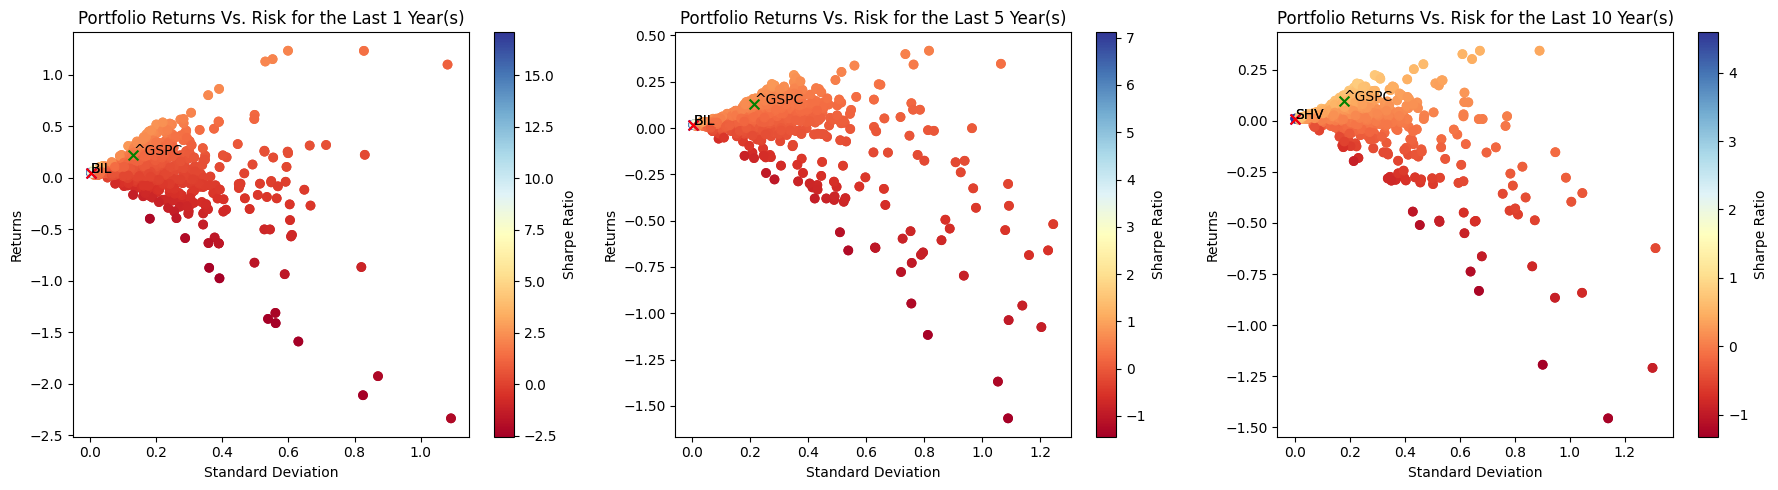

In [16]:
# Set up the figure and axes for a 1x3 grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the Risk vs Returns plots for all periods in separate subplots
for i, period in enumerate(periods):
    ax = axes[i]
    plot_risk_return(period, ax=ax)  # Assuming plot_risk_return accepts an axis argument

plt.tight_layout()
plt.show()

### Create a list of those ETFs where the returns or Sharpe ratio better than the S&P 500

In [17]:
# S&P 500 Metrics
sp500 = simulations_df.loc['^GSPC']
print(sp500)

top_etf = []  # Initialize top_etf as an empty list

for period in periods:

    # Capture the S&P 500 Return and Sharpe Ratio for each period
    return_col = 'Returns_' + str(period)
    sharpe_col = 'Sharpe Ratio_' + str(period)
    sp500_return = sp500[return_col]
    sp500_sharpe = sp500[sharpe_col]

    # Select 
    if not top_etf:  # Check if top_etf is empty
        top_etf = simulations_df[(simulations_df[return_col] > sp500_return) | (simulations_df[sharpe_col] > sp500_sharpe)].index.tolist()
    else:
        top_etf = list(set(top_etf + simulations_df[(simulations_df[return_col] > sp500_return) | (simulations_df[sharpe_col] > sp500_sharpe)].index.tolist()))

# Add S&P 500 to the top_etf
top_etf = top_etf + ['^GSPC']
print(f'The number of top ETF better than S&P 500 are {len(top_etf)}.')
print(top_etf)

simulations_df = simulations_df.loc[top_etf]
print(simulations_df.info())

Returns_1          0.223639
Volatility_1       0.130996
Sharpe Ratio_1     1.707222
Returns_5          0.128710
Volatility_5       0.214139
Sharpe Ratio_5     0.601055
Returns_10         0.095882
Volatility_10      0.178000
Sharpe Ratio_10    0.538660
Name: ^GSPC, dtype: float64
The number of top ETF better than S&P 500 are 356.
['IXN', 'EWZ', 'CSWC', 'USL', 'VONG', 'INDL', 'FTSL', 'XSD', 'DXJS', 'NEAR', 'IUSG', 'PWZ', 'MVV', 'PQTIX', 'FIDU', 'PTF', 'FLTR', 'ILF', 'PNQI', 'LQDH', 'ARCC', 'AGZD', 'VCR', 'AIRR', 'CSM', 'BRZU', 'XLY', 'PHO', 'MGK', 'FV', 'ILCG', 'PPA', 'FVD', 'VGT', 'IWY', 'VIS', 'SOXL', 'RAVI', 'ITB', 'XLK', 'PWB', 'SBSPX', 'PSCM', 'RSPN', 'KIE', 'XLG', 'EQWL', 'AOK', 'WTV', 'FNDX', 'GXG', 'INCO', 'IWV', 'PRN', 'TDTT', 'XME', 'SYLD', 'SPLG', 'SGOL', 'FTQI', 'RFV', 'TDIV', 'FCOM', 'MINT', 'WTMF', 'SPTM', 'PKB', 'MGC', 'ULST', 'UDOW', 'VUG', 'FTCS', 'SOCL', 'PKW', 'SCHB', 'PEZ', 'TFI', 'VDC', 'QTEC', 'MIDU', 'ISTB', 'FEZ', 'FDN', 'NLR', 'CARZ', 'EWT', 'VUSE', 'BIL', 'SPGP'

### Plot the returns, volatility and sharpe for all securities by period

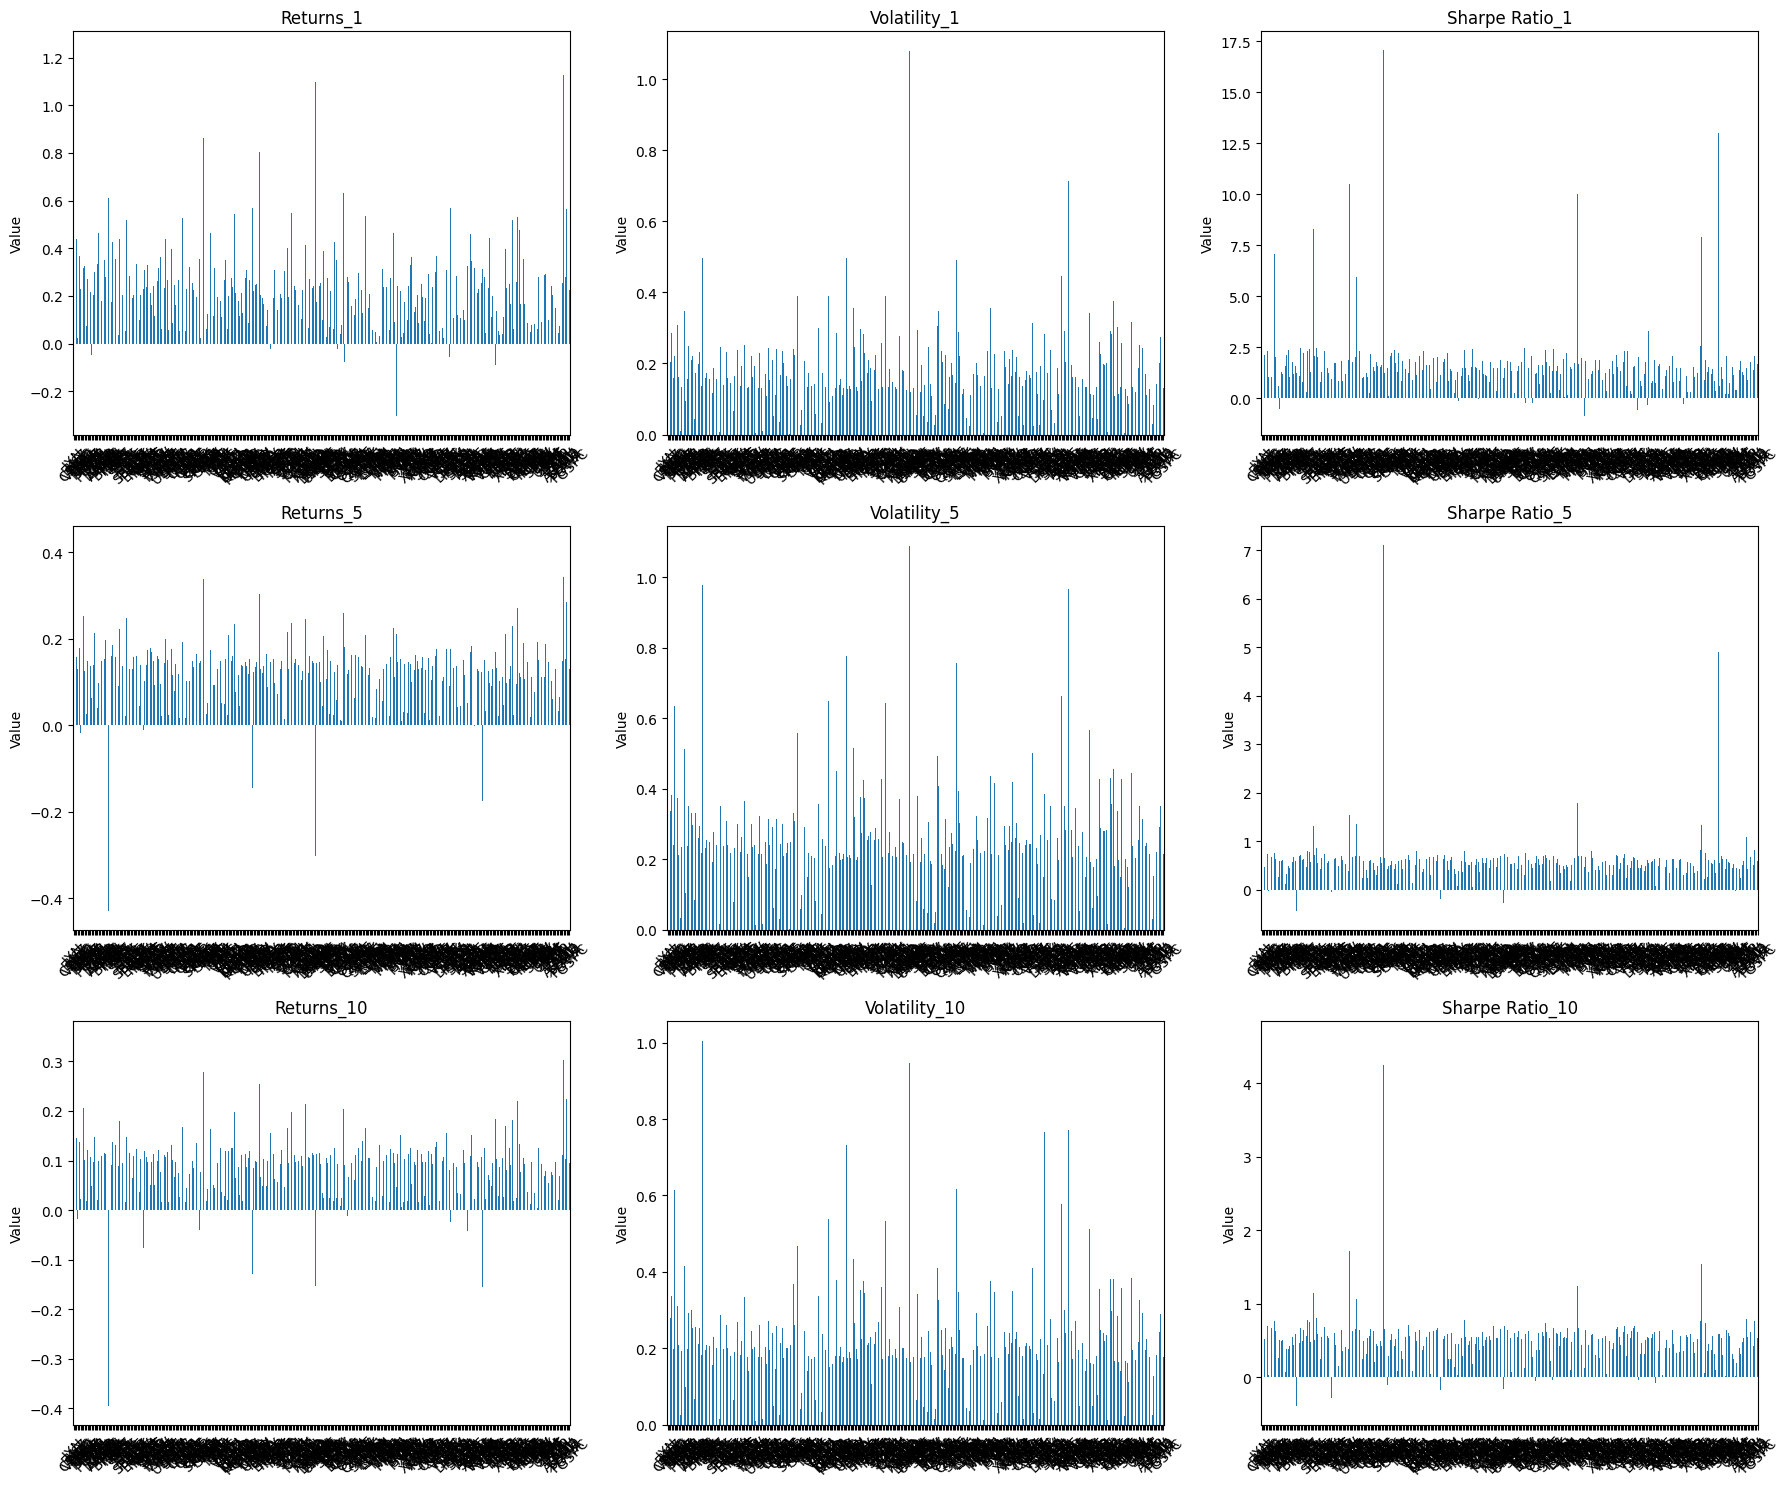

In [18]:
# Set up the figure and axes for a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Iterate over each column in simulations_df and create a bar plot in each subplot
for i, column in enumerate(simulations_df.columns):
    ax = axes_flat[i]
    simulations_df[column].plot(kind='bar', ax=ax)
    ax.set_title(column)
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

### Closing Price Trend

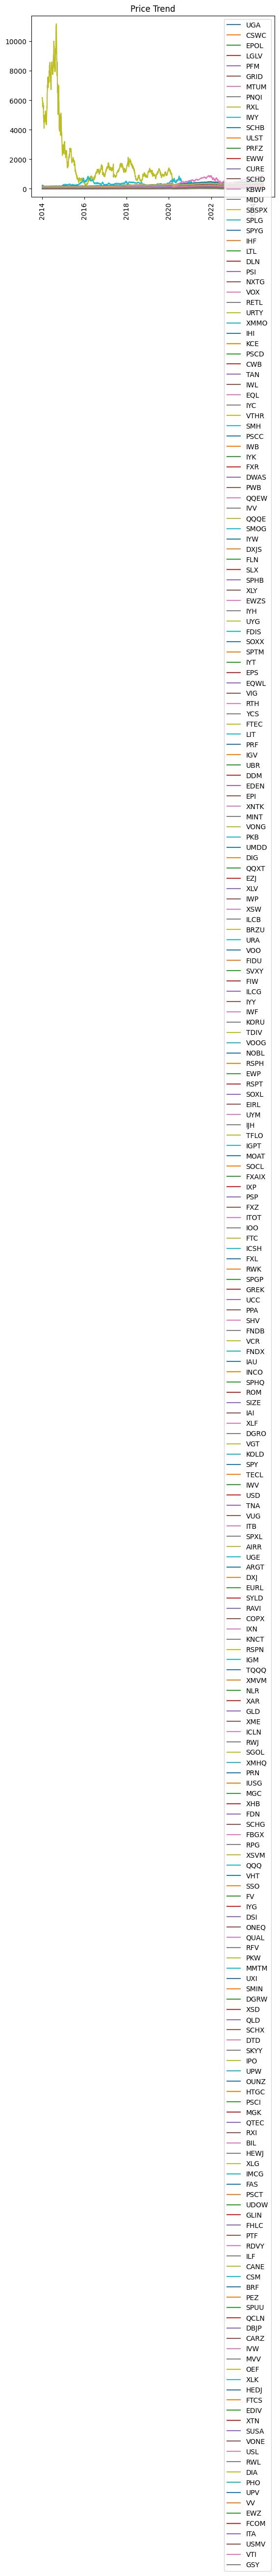

In [55]:
# Plot the close prices
plt.figure()
plt.plot(df.loc[:,top_etf[:-2]]) # Excluded S&P 500 because of scale
plt.title('Price Trend')
plt.legend(df.loc[:,top_etf[:-2]].columns)
plt.xticks(rotation=90)
plt.show()

### Correlations

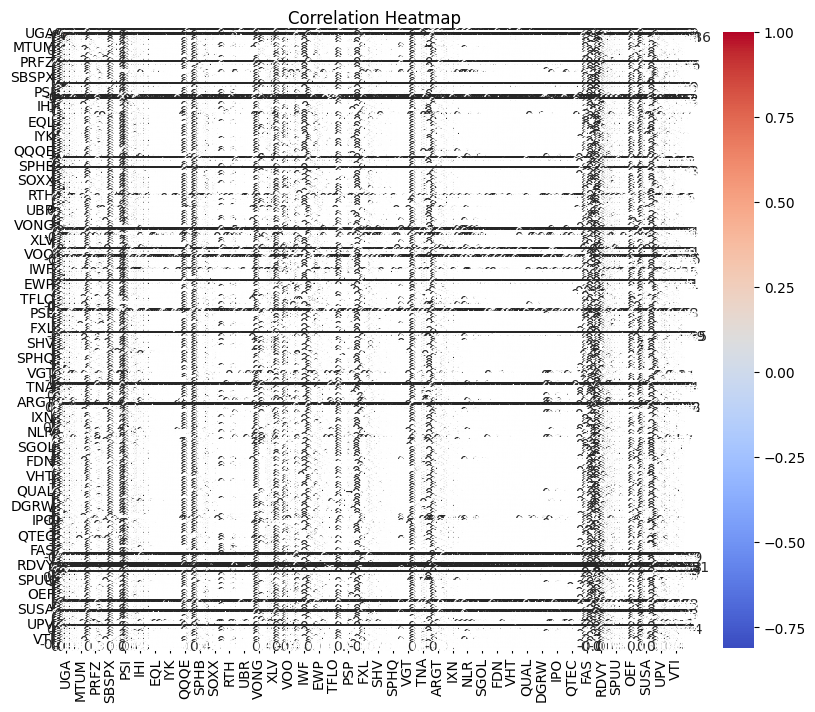

In [54]:
# Measure the correlation
import seaborn as sns

# Create a correlation matrix
corr_matrix = df.loc[:,top_etf].corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap using the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

## Calculate Portfolio Expected Value
This code is from [Sigma Coding](https://www.youtube.com/c/SigmaCoding).
https://github.com/areed1192/portfolio-optimization.git

In [19]:
# Define portfolio only with ETFs

symbols = df.loc[:,top_etf[:-2]].columns # Drop the S&P 500 Index
price_data_frame = df[symbols]

# of symbols we have, so let's save some time and just calculate that now.
number_of_symbols = len(symbols)
print(f'The portfolio has {number_of_symbols} ETFs to select from.')



The portfolio has 354 ETFs to select from.


In [57]:
# Calculate the Log of returns.
log_return = period_pct_change(price_data_frame, period=5)


# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
     random_weights  rebalance_weights
0          0.925797           0.007794
1          0.895935           0.007542
2          0.155668           0.001310
3          0.710326           0.005980
4          0.664870           0.005597
..              ...                ...
243        0.969054           0.008158
244        0.690475           0.005813
245        0.111703           0.000940
246        0.179291           0.001509
247        0.794498           0.006688

[248 rows x 2 columns]
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  \
0                    0.125038                       0.260366   

   Portfolio Sharpe Ratio  
0                 0.48024  
----------------------------------------

## Portfolio Optimization

### Monte Carlo

#### Define function to run Monte Carlo simuations for the specified period.

In [58]:
def monte_carlo(period=1, num_of_portfolios=5000):
    """
    Run Monte Carlo portfolio simulation to identify the max Sharpe ratio and the Min Volatility scenarios for the specified period.     
    Parameters:
    - period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    - num_of_portfolios (int): The number of simulations to run. Default is 5000.
    
    Returns:
    2 Dataframes, max_sharpe_ratio and min_volatility containing the period, annualized return, volatility, Sharpe ratio and the weights for each security.
    """   

    
    # Initialize the components, to run a Monte Carlo Simulation.

    # Get the log_return by calling the period_pct_change function
    log_return = period_pct_change(price_data_frame, period)

    # Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
    all_weights = np.zeros((num_of_portfolios, number_of_symbols))

    # Prep an array to store the returns as they are generated, 5000 possible return values.
    ret_arr = np.zeros(num_of_portfolios)

    # Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
    vol_arr = np.zeros(num_of_portfolios)

    # Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
    sharpe_arr = np.zeros(num_of_portfolios)

    # Start the simulations.
    for ind in range(num_of_portfolios):

        # First, calculate the weights.
        weights = np.array(np.random.random(number_of_symbols))
        weights = weights / np.sum(weights)

        # Add the weights, to the `weights_arrays`.
        all_weights[ind, :] = weights

        # Calculate the expected log returns, and add them to the `returns_array`.
        ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

        # Calculate the volatility, and add them to the `volatility_array`.
        vol_arr[ind] = np.sqrt(
            np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
        )

        # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
        sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

    # Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
    simulations_data = [np.full(num_of_portfolios, period), ret_arr, vol_arr, sharpe_arr, all_weights]

    # Create a DataFrame from it, then Transpose it so it looks like our original one.
    simulations_df = pd.DataFrame(data=simulations_data).T

    # Give the columns the Proper Names.
    simulations_df.columns = scenario_metric_columns[1:]
    
    # Make sure the data types are correct, we don't want our floats to be strings.
    simulations_df = simulations_df.infer_objects()

    # Return the Max Sharpe Ratio from the run.
    max_sharpe_ratio = pd.DataFrame(simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]).T # Select max sharpe scenario
    max_sharpe_ratio['Scenario'] = 'Monte Carlo Max Sharpe' # Assign Scenario name
    max_sharpe_ratio = max_sharpe_ratio[scenario_metric_columns] # Align columns in correct order

    # Return the Min Volatility from the run.
    min_volatility = pd.DataFrame(simulations_df.loc[simulations_df['Volatility'].idxmin()]).T # Select min volatility scenario
    min_volatility['Scenario'] = 'Monte Carlo Min Volatility' # Assign Scenario name
    min_volatility = min_volatility[scenario_metric_columns] # Align columns in correct order
    
    # This is so I can see the plot inside of my Jupyter Notebook.
    %matplotlib inline

    # Plot the data on a Scatter plot.
    plt.scatter(
        y=simulations_df['Returns'],
        x=simulations_df['Volatility'],
        c=simulations_df['Sharpe Ratio'],
        cmap='RdYlBu'
    )

    # Give the Plot some labels, and titles.
    plt.title(f'{period} Years Portfolio Returns Vs. Risk for {num_of_portfolios} scenarios')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Returns')

    # Plot the Max Sharpe Ratio, using a `Blue Star`.
    plt.scatter(
        max_sharpe_ratio['Volatility'],
        max_sharpe_ratio['Returns'],
        marker=(5, 1, 0),
        color='b',
        s=50
    )

    # Plot the Min Volatility, using a `Red Star`.
    plt.scatter(
        min_volatility['Volatility'],
        min_volatility['Returns'],
        marker=(5, 1, 0),
        color='r',
        s=50
    )

    # Finally, show the plot.
    plt.show()
    
    return max_sharpe_ratio, min_volatility

#### Call Monte Carlo for each period

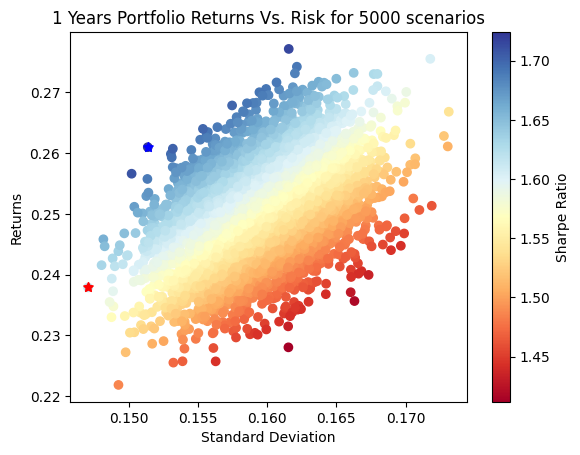

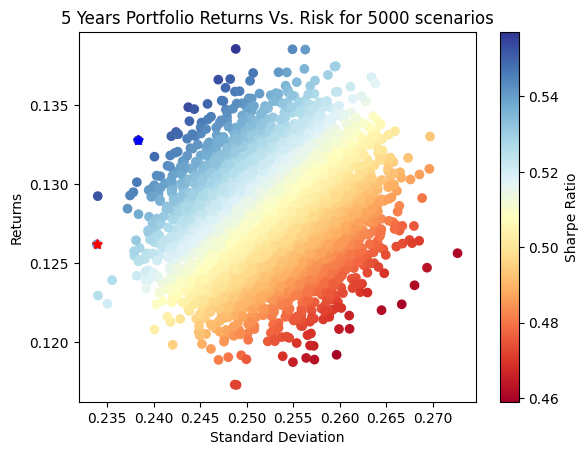

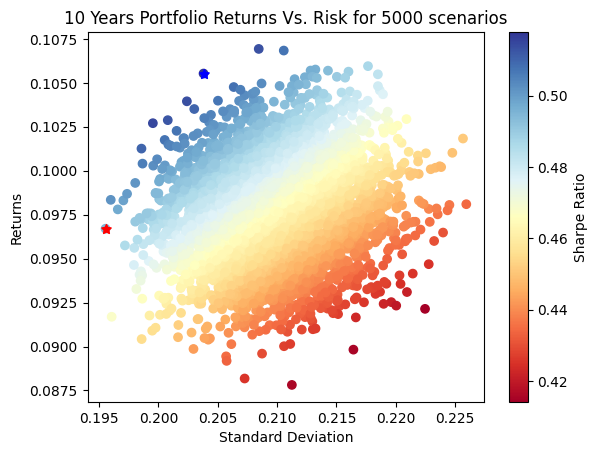


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
                    Scenario Period   Returns Volatility Sharpe Ratio  \
1158  Monte Carlo Max Sharpe      1  0.260962   0.151352     1.724203   
3725  Monte Carlo Max Sharpe      5  0.132783   0.238356     0.557079   
4325  Monte Carlo Max Sharpe     10  0.105529   0.203808     0.517788   

                                      Portfolio Weights  
1158  [0.0008348951530309624, 0.007698764054361008, ...  
3725  [0.007449265003101275, 0.0014809244399187583, ...  
4325  [0.0014802593240939503, 0.006020137280506409, ...  
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
                        Scenario Period   Returns Volatility Sharpe Ratio  \
2480  Monte Carlo Min Volatility      1  0.237896   0.147031        1.618   
1727  Monte Carlo Min Volatility      5  0

In [59]:
# Init the dataframe to collect the result
max_sharpe_ratio = pd.DataFrame()
min_volatility = pd.DataFrame()

# Create a loop to call the function to extract
for period in periods:
    if max_sharpe_ratio.empty: # Assume that both datasets are empty
        max_sharpe_ratio, min_volatility = monte_carlo(period=period, num_of_portfolios=5000)
    else:
        max_sharpe_ratio_temp, min_volatility_temp = monte_carlo(period=period, num_of_portfolios=5000)
        max_sharpe_ratio = pd.concat([max_sharpe_ratio, max_sharpe_ratio_temp])
        min_volatility = pd.concat([min_volatility, min_volatility_temp])
    
    
# Show the combined dataframe
print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)

### Scipy Optimization

#### Define Functions

In [20]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] * -1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

#### Define Max Sharpe Function

In [21]:
def optimized_sharpe(period=1):
    """
    Run Scipy Optimization to identify the max Sharpe ratio scenario for the specified period. 
    Parameters:
    - period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    
    Returns:
    Dataframe for max_sharpe_ratio containing the period, annualized return, volatility, Sharpe ratio and the weights for each security.
    """   
    
    
    # Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
    bounds = tuple((0, 1) for symbol in range(number_of_symbols))

    # Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
    constraints = ({'type': 'eq', 'fun': check_sum})

    # We need to create an initial guess to start with,
    # and usually the best initial guess is just an
    # even distribution. In this case 25% for each of the 4 stocks.
    init_guess = number_of_symbols * [1 / number_of_symbols]

    # Perform the operation to minimize the risk.
    optimized_sharpe = sci_opt.minimize(
        grab_negative_sharpe, # minimize this.
        init_guess, # Start with these values.
        method='SLSQP',
        bounds=bounds, # don't exceed these bounds.
        constraints=constraints # make sure you don't exceed the 100% constraint.
    )
    
    # Grab the metrics.
    optimized_max_sharpe_metrics = get_metrics(weights=optimized_sharpe.x)
    
    # Return Combined the metrics and weights into one data frame and return   
        # Return Combined the metrics and weights into one data frame and return   
    return pd.DataFrame([['Scipy Max Sharpe', period, optimized_max_sharpe_metrics[0], optimized_max_sharpe_metrics[1], optimized_max_sharpe_metrics[2], optimized_sharpe.x]], columns = scenario_metric_columns)

#### Define Min Volatility Function

In [22]:
def optimized_volatility(period=1):
    """
    Run Scipy Optimization to identify the min volatility scenario for the specified period. 
    Parameters:
    - period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    
    Returns:
    Dataframe for min_volatility containing the period, annualized return, volatility, Sharpe ratio and the weights for each security.
    """   
    
    # Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
    bounds = tuple((0, 1) for symbol in range(number_of_symbols))

    # Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
    constraints = ({'type': 'eq', 'fun': check_sum})

    # We need to create an initial guess to start with,
    # and usually the best initial guess is just an
    # even distribution. In this case 25% for each of the 4 stocks.
    init_guess = number_of_symbols * [1 / number_of_symbols]

    # Perform the operation to minimize the risk.
    optimized_volatility = sci_opt.minimize(
        grab_volatility, # minimize this.
        init_guess, # Start with these values.
        method='SLSQP',
        bounds=bounds, # don't exceed these bounds.
        constraints=constraints # make sure you don't exceed the 100% constraint.
    )

    # Grab the metrics.
    optimized_min_volatility_metrics = get_metrics(weights=optimized_volatility.x)
    
    # Return Combined the metrics and weights into one data frame and return   
    return pd.DataFrame([['Scipy Min Volatility', period, optimized_min_volatility_metrics[0], optimized_min_volatility_metrics[1], optimized_min_volatility_metrics[2], optimized_volatility.x]], columns = scenario_metric_columns)

#### Call functions for each period and capture the results

In [23]:
# Init the dataframe to collect the result
optimized_max_sharpe_metrics  = pd.DataFrame()
optimized_min_volatility_metrics = pd.DataFrame()

for period in periods:
    # Get the log_return by calling the period_pct_change function
    log_return = period_pct_change(price_data_frame, period)
    
    if optimized_max_sharpe_metrics.empty: # Assume that both datasets are empty 
        # Call optimized_sharpe
        optimized_max_sharpe_metrics = optimized_sharpe(period)
        # Call optimized_volatility
        optimized_min_volatility_metrics = optimized_volatility(period)
    else:
        # Call optimized_sharpe
        optimized_max_sharpe_metrics = pd.concat([optimized_max_sharpe_metrics, optimized_sharpe(period)], ignore_index=True)
        # Call optimized_volatility
        optimized_min_volatility_metrics = pd.concat([optimized_min_volatility_metrics, optimized_volatility(period)], ignore_index=True)
        
    
# Combine metrics
print(optimized_max_sharpe_metrics)
print(optimized_min_volatility_metrics)

: 

## Evaluate Scenarios

### Combine all scenarios and extract the portfolio weights

In [24]:
# List the scenarios
scenarios = ['Monte Carlo Max Sharpe', 'Monte Carlo Min Volatility',  'Scipy Max Sharpe', 'Scipy Min Volatility']

# Combine all the scenarios into one dataframe for summary
df_portfolio_metrics_scenarios = pd.concat([max_sharpe_ratio.iloc[:,:5], min_volatility.iloc[:,:5], optimized_max_sharpe_metrics.iloc[:,:5], optimized_min_volatility_metrics.iloc[:,:5]], ignore_index=True)

# Extract the portfolio weights for each scenario and period
df_portfolio_weights_scenarios = pd.concat([max_sharpe_ratio[['Scenario', 'Period', 'Portfolio Weights']], min_volatility[['Scenario', 'Period', 'Portfolio Weights']], optimized_max_sharpe_metrics[['Scenario', 'Period', 'Portfolio Weights']], optimized_min_volatility_metrics[['Scenario', 'Period', 'Portfolio Weights']]], ignore_index=True).set_index(['Scenario', 'Period'])

# Expand the 'Portfolio Weights' lists into their own dataframe
weights_df = pd.DataFrame(df_portfolio_weights_scenarios['Portfolio Weights'].tolist(), columns=symbols, index=df_portfolio_weights_scenarios.index).reset_index()

# Join the expanded weights back with the original dataframe (if needed) or just work with the weights_df
df_portfolio_metrics_scenarios = df_portfolio_metrics_scenarios.merge(weights_df, on=['Scenario', 'Period'], how='inner')

### Calculate the current portfolio's expected returns, volatility and sharpe ratios

In [25]:
def define_scenarios(portfolio_weights_dict):
    """
    This function calcuate the returns, volatility and sharpe ratio for a pre-defined portfolio weights for each period. 
    
    Parameters:
    - portfolio_weights_dict (dict): Must include the 'Scenario' name and the security symbols as keys and their corresponding weights. All weights should equal to 1.
    
    Returns:
    Dataframe with the calculated returns, volatility, sharpe ratio and weights for all symbols.
    """       
    # Init new_row as an empty list
    new_row = []

    # Assign values for the new_row to add the portfolio scenarios
    for period in periods:
        portfolio_metrics_dict = {'Scenario': portfolio_weights_dict['Scenario'], 'Period': period, 'Returns': 0, 'Volatility': 0, 'Sharpe Ratio': 0} 
        symbols_zero_dict = {symbol: 0 for symbol in symbols}
        # Update symbols_zero_dict with the weights from current_portfolio_weights_dict
        for key, value in portfolio_weights_dict.items():
            if key in symbols_zero_dict:
                symbols_zero_dict[key] = value
        portfolio_metrics_dict.update(symbols_zero_dict)
        new_row = new_row + [portfolio_metrics_dict]
    
    # Convert to a dataframe
    new_rows = pd.DataFrame(new_row)

    # Calculate the metrics for each period
    for period in periods:  
        # Extract from simulations_df the period
        returns = simulations_df[:-2].T.loc['Returns_'+str(period)]
        volatility = simulations_df[:-2].T.loc['Volatility_'+str(period)]
        weights = new_rows[new_rows['Period']==period].iloc[:,5:].T

        # Calculate the sum product of returns and weights
        sum_product_returns = (returns * weights.squeeze()).sum()

        # Update the 'Returns' column in the new_rows dataframe
        new_rows.loc[new_rows['Period'] == period, 'Returns'] = sum_product_returns

        # Assuming similar calculation for 'Volatility' if needed here
        sum_product_volatility = (volatility * weights.squeeze()).sum()
        new_rows.loc[new_rows['Period'] == period, 'Volatility'] = sum_product_volatility

    # Calculate the Sharpe Ratio
    new_rows['Sharpe Ratio'] = new_rows['Returns'] / new_rows['Volatility']

    return new_rows

In [26]:
# Current Portfolio Weights
current_portfolio_weights_dict = {'Scenario': 'Current Portfolio', 'SCHG': 0.50, 'YCS': 0.10, 'CSWC': 0.10, 'EQWL': 0.10, 'VOO': 0.10, 'FXAIX': 0.10}
charles_schwab_weights_dict = {'Scenario': 'Charles Schwab', 'MDYG': 0.1276,  'MDYV': 0.0768,  'SCHE': 0.0666,  'SCHF': 0.2241,  'SCHG': 0.2129,  'SCHV': 0.1796, 'SLYG': 0.0577, 'SLYV': 0.0548, 'TECB': 0.0499}

# Append the pre-defined weight scenarios to df_portfolio_metrics_scenarios
df_portfolio_metrics_scenarios = pd.concat([df_portfolio_metrics_scenarios, define_scenarios(current_portfolio_weights_dict)], ignore_index=True)
df_portfolio_metrics_scenarios = pd.concat([df_portfolio_metrics_scenarios, define_scenarios(charles_schwab_weights_dict)], ignore_index=True)

# Show scenario results
df_portfolio_metrics_scenarios.round(4)

C:\Users\sean1\AppData\Local\Temp\ipykernel_21924\849918093.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.31968248944610567' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_rows.loc[new_rows['Period'] == period, 'Returns'] = sum_product_returns
C:\Users\sean1\AppData\Local\Temp\ipykernel_21924\849918093.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.14445491243469175' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_rows.loc[new_rows['Period'] == period, 'Volatility'] = sum_product_volatility
C:\Users\sean1\AppData\Local\Temp\ipykernel_21924\849918093.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19689773967565713' has dtype inc

,Scenario,Period,Returns,Volatility,Sharpe Ratio,HILIX,MDYV,HTGC,DXJ,USMV,...,QUSIX,DLN,HEWJ,MDYG,SCHV,SCHG,SCHF,SLYG,ATMP,MIOIX
0,Monte Carlo Max Sharpe,1,0.235144,0.117286,2.004881,0.0350,0.0028,0.0043,0.0306,0.0221,...,0.0357,0.0017,0.0269,0.0265,0.0136,0.0421,0.0014,0.0260,0.0402,0.0034
1,Monte Carlo Max Sharpe,5,0.11619,0.183319,0.633816,0.0174,0.0047,0.0378,0.0301,0.0343,...,0.0116,0.0425,0.0320,0.0382,0.0233,0.0452,0.0010,0.0004,0.0150,0.0441
2,Monte Carlo Max Sharpe,10,0.083342,0.152496,0.54652,0.0218,0.0439,0.0309,0.0135,0.0367,...,0.0121,0.0161,0.0091,0.0015,0.0234,0.0382,0.0237,0.0313,0.0021,0.0085
3,Monte Carlo Min Volatility,1,0.201644,0.106143,1.899739,0.0321,0.0080,0.0057,0.0168,0.0406,...,0.0404,0.0044,0.0113,0.0232,0.0065,0.0362,0.0344,0.0129,0.0489,0.0129
4,Monte Carlo Min Volatility,5,0.104435,0.173346,0.602469,0.0367,0.0029,0.0144,0.0157,0.0233,...,0.0350,0.0200,0.0408,0.0116,0.0216,0.0044,0.0020,0.0015,0.0102,0.0276
5,Monte Carlo Min Volatility,10,0.073963,0.146739,0.504047,0.0280,0.0046,0.0150,0.0070,0.0253,...,0.0525,0.0043,0.0244,0.0210,0.0441,0.0111,0.0263,0.0294,0.0210,0.0239
6,Scipy Max Sharpe,1,0.329856,0.105938,3.11367,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.1428,0.0000,0.0000,0.0000,0.0000,0.3173,0.0000,0.0000,0.0000,0.0000
7,Scipy Max Sharpe,5,0.098411,0.075305,1.306826,0.0000,0.0000,0.0207,0.0000,0.0000,...,0.1422,0.0000,0.0000,0.0000,0.0000,0.1376,0.0000,0.0000,0.0000,0.0000
8,Scipy Max Sharpe,10,0.074673,0.070642,1.05706,0.0000,0.0000,0.0000,0.0000,0.1306,...,0.1097,0.0000,0.0000,0.0000,0.0000,0.1099,0.0000,0.0000,0.0000,0.0000
9,Scipy Min Volatility,1,0.070871,0.059933,1.182506,0.0000,0.0000,0.0000,0.0000,0.2785,...,0.1284,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### Plot the Scenario Risk and Rewards by Period

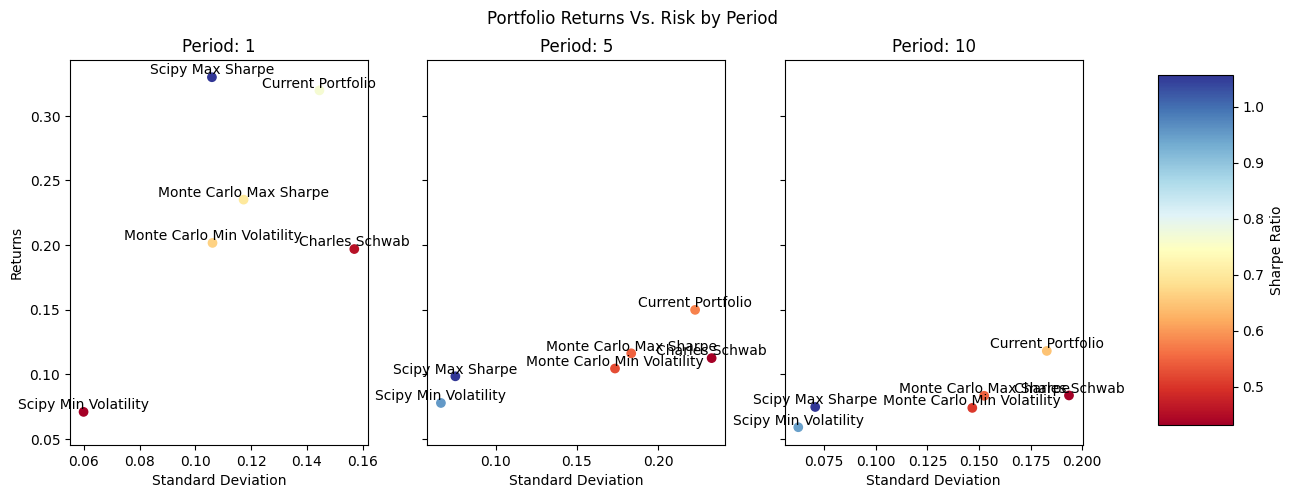

In [27]:
num_periods = len(periods)

fig, axs = plt.subplots(1, num_periods, figsize=(5*num_periods, 5), sharey=True)

for i, period in enumerate(periods):
    # Filter the dataframe for the current period
    df_period = df_portfolio_metrics_scenarios[df_portfolio_metrics_scenarios['Period'] == period]
    
    # Plotting
    sc = axs[i].scatter(data=df_period, x='Volatility', y='Returns', c='Sharpe Ratio', cmap='RdYlBu')
    
    # Adding text labels
    for index, row in df_period.iterrows():
        axs[i].text(row['Volatility'], row['Returns'], row['Scenario'], va='bottom', ha='center')
    
    # Setting titles and labels
    axs[i].set_title(f'Period: {period}')
    axs[i].set_xlabel('Standard Deviation')
    if i == 0:  # Only add y label to the first subplot to avoid repetition
        axs[i].set_ylabel('Returns')

# Adjusting the layout to make room for the colorbar
fig.subplots_adjust(right=0.8)

# Adding a colorbar
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])  # This adds a new axis for the colorbar
fig.colorbar(sc, cax=cbar_ax, orientation='vertical', label='Sharpe Ratio')

plt.suptitle('Portfolio Returns Vs. Risk by Period')
plt.show()

### Plot the Portfolio Allocation for scenarios by periods

C:\Users\sean1\AppData\Local\Temp\ipykernel_21924\4045807162.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df_period.columns[1:], rotation=90)
C:\Users\sean1\AppData\Local\Temp\ipykernel_21924\4045807162.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df_period.columns[1:], rotation=90)
C:\Users\sean1\AppData\Local\Temp\ipykernel_21924\4045807162.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df_period.columns[1:], rotation=90)


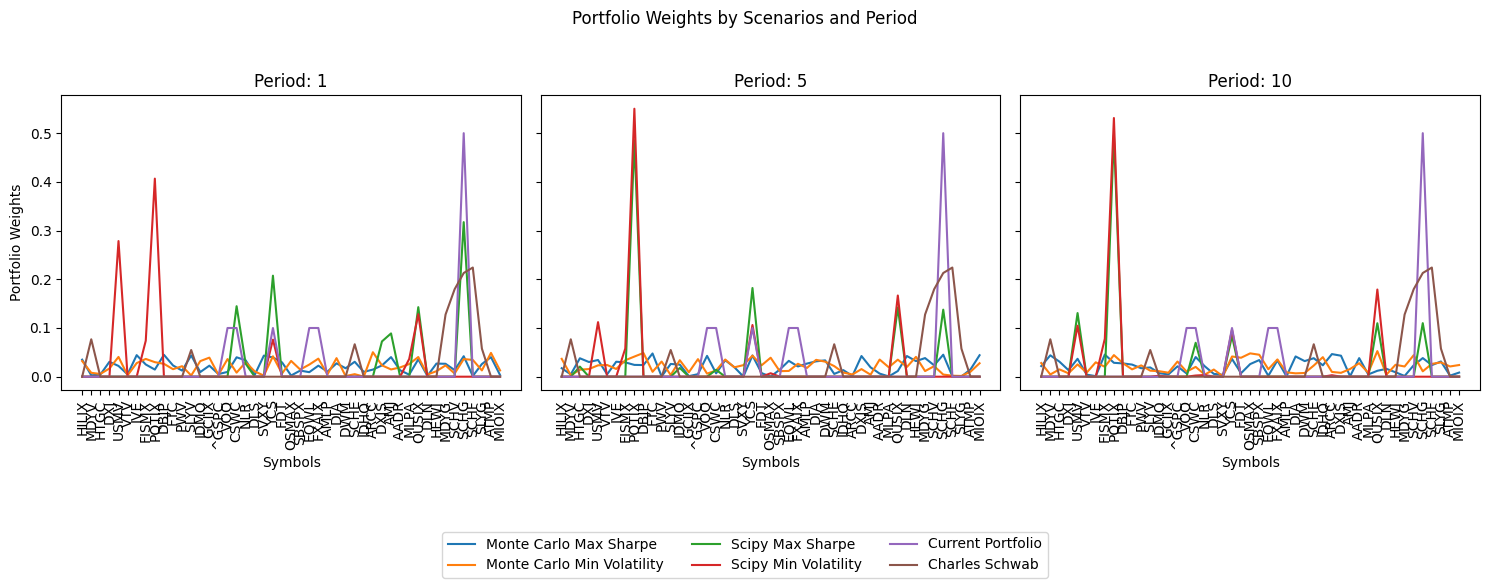

In [28]:
num_periods = len(periods)
fig, axs = plt.subplots(1, num_periods, figsize=(5*num_periods, 5), sharey=True)

lines = []  # To store the line objects for the legend
labels = []  # To store the labels for the legend

for i, period in enumerate(periods):
    # Filter the dataframe for the current period
    df_period = df_portfolio_metrics_scenarios[df_portfolio_metrics_scenarios['Period'] == period]
    df_period = df_period.drop(['Period', 'Returns', 'Volatility', 'Sharpe Ratio'], axis=1)
    
    # Assuming the first column is 'Scenario' and the rest are portfolio weights
    # Plot and collect line objects for legend
    lines += axs[i].plot(df_period.iloc[:, 1:].T)
    axs[i].set_title(f'Period: {period}')
    axs[i].set_xlabel('Symbols')
    axs[i].set_xticklabels(df_period.columns[1:], rotation=90)
    if i == 0:  # Only add y label to the first subplot to avoid repetition
        axs[i].set_ylabel('Portfolio Weights')
    
    # Collecting scenario names for legend
    if i == 0:  # Assuming scenario names are the same for all periods, so only do this once
        labels = df_period['Scenario'].unique()

# Placing one legend below the plots
fig.legend(lines[:len(labels)], labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.suptitle('Portfolio Weights by Scenarios and Period')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the legend
plt.show()

### Review the correlation of the Max Scipy Sharpe investments with >1% allocation

In [29]:
# Select a list of securities fr the Max Scipy Sharpe with an allocation weight greater than 0.01
scipy_max_sharpe_securities = df_portfolio_metrics_scenarios.loc[df_portfolio_metrics_scenarios['Scenario']=='Scipy Max Sharpe'].iloc[:,5:].columns[(df_portfolio_metrics_scenarios.loc[df_portfolio_metrics_scenarios['Scenario']=='Scipy Max Sharpe'].iloc[:,5:] > 0.01).any()]

print(f"These securities, {scipy_max_sharpe_securities}, are selected for the Scipy Max Sharpe scenario for all periods.")

These securities, Index(['HTGC', 'USMV', 'PQTIX', 'IDMO', 'CSWC', 'NLR', 'YCS', 'DXJS', 'AMJ',
       'QUSIX', 'SCHG'],
      dtype='object'), are selected for the Scipy Max Sharpe scenario for all periods.


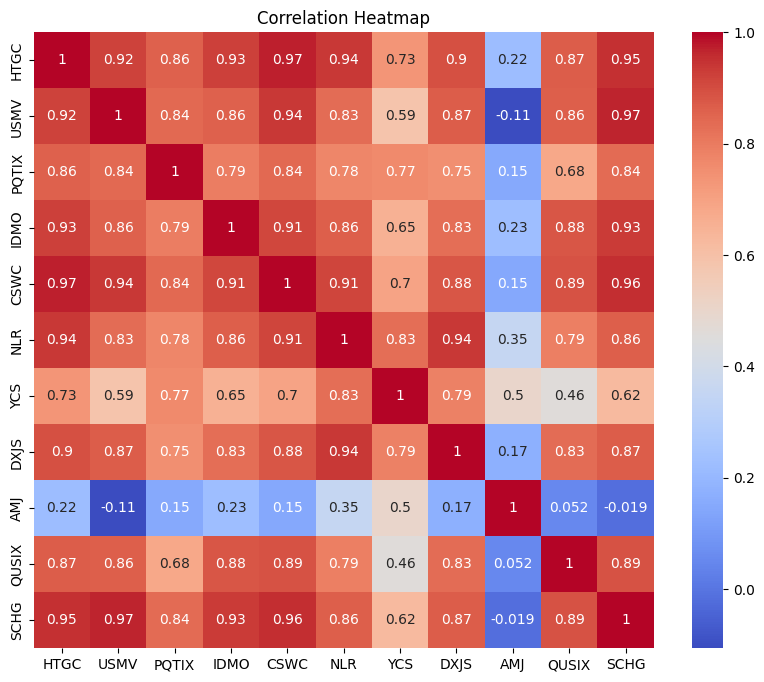

In [30]:
# Show correlation matrix for Scipy Max Sharpe Scenarios
scipy_max_sharpe_corr_matrix = df.loc[:, scipy_max_sharpe_securities].corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap using the correlation matrix
sns.heatmap(scipy_max_sharpe_corr_matrix, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

### Show portfolio weights for the Scipy Max Sharpe scenario

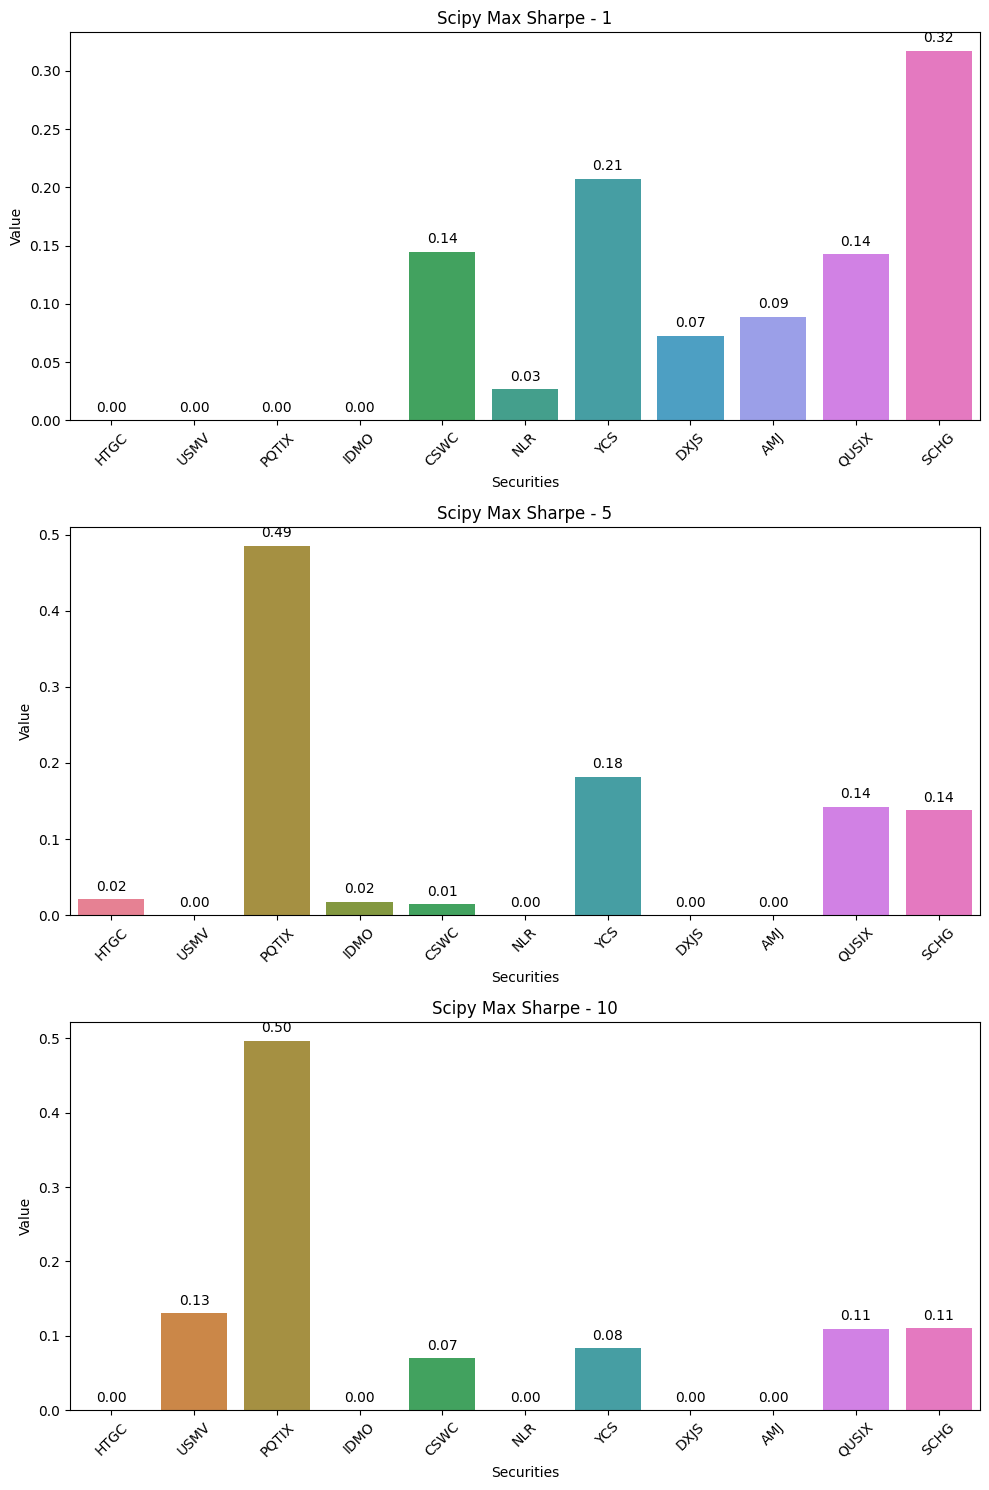

In [31]:
# Filter the dataframe for the 'Scipy Max Sharpe' scenario
scipy_max_sharpe_df = df_portfolio_metrics_scenarios[df_portfolio_metrics_scenarios['Scenario'] == 'Scipy Max Sharpe']

# Set up the matplotlib figure
fig, axes = plt.subplots(len(periods), 1, figsize=(10, 5 * len(periods)))

# Check if there is only one period, to avoid indexing issues
if len(periods) == 1:
    axes = [axes]

for i, period in enumerate(periods):
    # Filter the dataframe for the current period
    period_df = scipy_max_sharpe_df[scipy_max_sharpe_df['Period'] == period]
    
    # Select only the securities columns for the current period
    securities_df = period_df.loc[:, scipy_max_sharpe_securities]
    
    # Plot
    ax = sns.barplot(data=securities_df, ax=axes[i])
    axes[i].set_title(f'Scipy Max Sharpe - {period}')
    axes[i].set_ylabel('Value')
    axes[i].set_xlabel('Securities')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add labels on top of the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()